<a href="https://colab.research.google.com/github/sazizian/Lambda/blob/master/model_with_RBP_pssm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Essential imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models

# Drive mounting
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



files = !ls "/content/drive/My Drive/Data_Final_Code"
for file in files:
  print(file)

pssm_path = '/content/drive/My Drive/Data_Final_Code/PSSM-Data'
# RBP_path = '/content/drive/My Drive/Data_Final_Code/RBP-Data/'
RBP_path = '/content/drive/My Drive/Data_Final_Code/RBP-Data-Sample/'

num_files = len(os.listdir(pssm_path))

print(f"Number of files in {pssm_path}: {num_files}")

Mounted at /content/drive
destination.zip		   PSSM-Data  RBP-Data-Sample	Test
model_with_RBP_pssm.ipynb  RBP-Data   split_files2.zip	Untitled1.ipynb
Number of files in /content/drive/My Drive/Data_Final_Code/PSSM-Data: 498


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
import torch

if torch.cuda.is_available():
    print(f'GPU available: {torch.cuda.get_device_name(0)}')
else:
    print("Please check the GPU settings in Colab")


GPU available: Tesla V100-SXM2-16GB


# **Load and Process PSSM**

In [5]:
import numpy as np
import os

class PSSMProcessor:
    def __init__(self, path):
        self.path = path
        self.final_array = None

    def load_and_adjust_pssms(self):
        def load_pssm(file):
            alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
            with open(file, 'r') as f:
                lines = f.readlines()
            pssm = []
            for line in lines[3:-6]:
                pssm.append([int(x) for x in line.split()[2:22]])
            return np.array(pssm)

        pssm_files = [os.path.join(self.path, f) for f in os.listdir(self.path) if f.endswith('.pssm')]
        pssm_data = []

        for file in pssm_files:
            pssm_matrix = load_pssm(file)
            if pssm_matrix.size == 0:
                print(f"File with zero-size PSSM matrix: {file}")
            else:
                filename = os.path.basename(file)
                pssm_data.append((filename, pssm_matrix))

        min_length, max_length, average_length = self.adjust_pssm_to_average_length(pssm_data)
        print(f"Min length: {min_length}, Max length: {max_length}, Average length: {average_length}")
        # Initialize pssm_dict here, right before filling it
        pssm_dict = {}
        for item in self.final_array:
            if "-" in item[0]:
                key_part = item[0].split('-')[0]
            else:
                key_part = item[0].split('_')[0]
            pssm_data = item[1]
            if len(pssm_data) == 0:
                print(f"Empty PSSM data for file: {item[0]}, Data: {item[1]}")
            else:
                pssm_dict[key_part] = pssm_data

        return pssm_dict  # Ensure this return statement is included

    def adjust_pssm_to_average_length(self, pssm_data):
        lengths = [pssm.shape[0] for _, pssm in pssm_data]
        min_length = min(lengths)
        max_length = max(lengths)
        average_length = sum(lengths) // len(lengths)

        adjusted_pssms = []
        for filename, pssm in pssm_data:
            if pssm.shape[0] > average_length:
                adjusted_pssm = pssm[:average_length]
            elif pssm.shape[0] < average_length:
                repeat_times = average_length // pssm.shape[0] + 1
                extended_pssm = np.tile(pssm, (repeat_times, 1))[:average_length]
                adjusted_pssm = extended_pssm
            else:
                adjusted_pssm = pssm
            adjusted_pssms.append((filename, adjusted_pssm.flatten()))

        self.final_array = np.array(adjusted_pssms, dtype=object)
        return min_length, max_length, average_length


In [6]:

processor = PSSMProcessor(pssm_path)
pssm_data_dict =processor.load_and_adjust_pssms()
# pssm_data_dict = processor.generate_random_rows(300)
print(f"Number of entries in PSSM data dictionary: {len(pssm_data_dict)}")

# Print the first few entries to verify
for key in list(pssm_data_dict.keys())[:10]:  # Adjust the number to print as needed
    print(f"Key: {key}, Length of PSSM row vector: {len(pssm_data_dict[key])}")
    # print(f"Key: {key}, Length of PSSM row vector: {len(pssm_data_dict[key])}, PSSM DATA: {pssm_data_dict[key]}")

Min length: 26, Max length: 3820, Average length: 403
Number of entries in PSSM data dictionary: 498
Key: BCLA3, Length of PSSM row vector: 8060
Key: AKAP8, Length of PSSM row vector: 8060
Key: CSTF2T, Length of PSSM row vector: 8060
Key: B4DU03.pssm, Length of PSSM row vector: 8060
Key: B2RUW4.pssm, Length of PSSM row vector: 8060
Key: A0A087WWW8.pssm, Length of PSSM row vector: 8060
Key: A0A7I2V3L8.pssm, Length of PSSM row vector: 8060
Key: A0A2H4G0L5.pssm, Length of PSSM row vector: 8060
Key: D6RA83.pssm, Length of PSSM row vector: 8060
Key: A0A678ZDL3.pssm, Length of PSSM row vector: 8060


# **Principal Component Analysis (PCA)**

In [7]:
import pandas as pd

# Assuming pssm_data_dict is already filled with your data
# Convert the dictionary values (which are the PSSM arrays) into a list of lists
data = [value for key, value in pssm_data_dict.items()]

# Create the DataFrame from this data
df = pd.DataFrame(data)
df = df[df.columns[:num_files]]

# Rename the columns as specified
df.columns = ['x' + str(col) for col in df.columns]

# Display the DataFrame
print(df.head())


   x0  x1  x2  x3  x4  x5  x6  x7  x8  x9  ...  x488  x489  x490  x491  x492  \
0  -4  -4  -5  -6  -4  -3  -5  -5  -4  -1  ...     6    -4    -4     1    -3   
1  -2  -2  -3  -4  -2  -1  -3  -3  -2   1  ...    -1    -3    -2    -1     0   
2  -1  -2  -3  -4  -2  -1  -3  -3  -2   1  ...     1    -2    -2    -4    -3   
3  -4  -5  -5  -6  -5  -3  -5  -6  -5  -2  ...     0     1     1     0     0   
4  -3  -4  -5  -5  -3  -4  -5  -5  -4   2  ...    -1    -1     4    -2     1   

   x493  x494  x495  x496  x497  
0    -1     1     0    -3    -3  
1    -2    -2     0    -1    -2  
2     4    -2    -2    -4     2  
3    -1     2     0    -1    -2  
4     2    -4    -2    -1     1  

[5 rows x 498 columns]


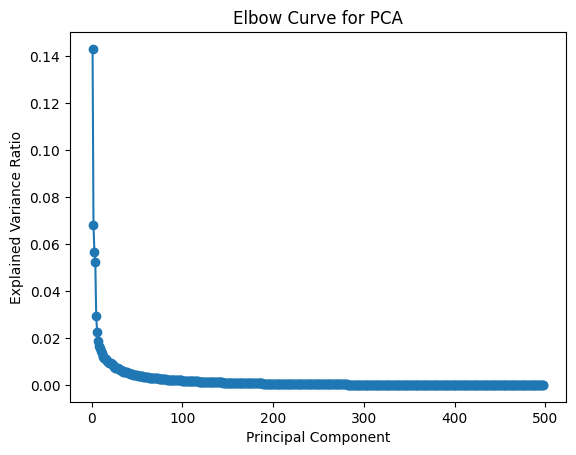

In [8]:
# prompt: applay PCA to df and give anaysis of elbow curve for optimaration

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to the data
pca = PCA()
pca.fit(df)

# Plot the elbow curve
plt.plot(range(1, len(df.columns) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Curve for PCA')
plt.show()

# Analyze the elbow curve to determine the optimal number of principal components to retain
# Look for the point where the explained variance ratio starts to level off
# In this case, it appears that retaining around 100 principal components would capture most of the variance in the data

# Perform PCA with the chosen number of components



In [9]:
pca = PCA(n_components=25)
df_pca = pca.fit_transform(df)

# Print the transformed data
print(df_pca[0])
type(df_pca)

[-11.03213407   0.07239904  -6.08248781 -15.75490619   1.95071888
  -8.80919161   2.50061906  -2.19213516   3.71377834  -1.04328802
   7.00591821  -1.77963411  -3.54837106  -2.44060273  -6.86498633
  -1.85530682  -2.6654622   -1.96101553   0.83766059  -4.24490182
   2.10080628   5.22336744  -7.06776313  -3.29292796   1.28828547]


numpy.ndarray

In [10]:
import pandas as pd
from sklearn.decomposition import PCA

# Assuming pssm_data_dict is already filled with your data
# Convert the dictionary values (which are the PSSM arrays) into a list of lists
data = [value for key, value in pssm_data_dict.items()]

# Create the DataFrame from this data
df = pd.DataFrame(data)
# Assuming 'num_files' is defined; if not, replace df.columns[:num_files] with appropriate slicing or remove if unnecessary
# df = df[df.columns[:num_files]] # Uncomment if num_files is defined and you need to slice the DataFrame

# Rename the columns as specified
df.columns = ['x' + str(col) for col in df.columns]
# print(df.head())

# Apply PCA to the data
pca = PCA(n_components=25)  # Directly initializing PCA with n_components=25
df_pca = pca.fit_transform(df)


# Print the explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
# Creating a new dictionary with the same keys and the PCA-transformed data as values
keys = list(pssm_data_dict.keys())
pssm_data_pca_dict = {keys[i]: df_pca[i] for i in range(len(keys))}

# Now, pssm_data_pca_dict contains the original keys and the PCA-transformed data
print(f"Number of entries in PSSM data dictionary: {len(pssm_data_pca_dict)}")

# Print the first few entries to verify
for key in list(pssm_data_pca_dict.keys())[:1]:  # Adjust the number to print as needed
    print(f"Key: {key}, Length of PSSM row vector: {len(pssm_data_pca_dict[key])}, PSSM DATA: {pssm_data_pca_dict[key]}")

Explained variance ratio: [0.09807939 0.05417203 0.02754099 0.02566065 0.01996387 0.01638875
 0.01491769 0.01409852 0.01265453 0.01059921 0.00962681 0.00752364
 0.00712155 0.00640233 0.00619553 0.00604614 0.00590638 0.0055506
 0.00534181 0.00530673 0.0050598  0.00502135 0.00499425 0.00482526
 0.00470439]
Number of entries in PSSM data dictionary: 498
Key: BCLA3, Length of PSSM row vector: 25, PSSM DATA: [-5.67889986e+01 -6.51307634e+01 -4.51984580e+01  2.13063402e+01
  1.06448010e+00  2.46420320e+01  1.31076157e+00 -7.11722882e+00
  4.97390778e+00  1.40370281e+01  2.91811471e+01  1.39799276e+00
  2.61398992e+01 -1.88408028e+00  1.33708155e-01 -3.65118940e-01
  2.94284826e+00 -1.18388400e+01 -8.80353997e+00  2.90730463e+00
  1.26848105e+01  9.62173580e+00  4.02863339e+00 -3.46925956e+00
 -4.76563059e-02]


**Create data fro Negative PSSM**

In [11]:
# Create a new dictionary to store the PCA-transformed data with negative signs
pssm_data_pca_negative_dict = {}

# Iterate through the original dictionary and multiply each value by -1 to change the signs
for key, value in pssm_data_pca_dict.items():
    pssm_data_pca_negative_dict[key] = value * -1

# Print the first few entries to verify
for key in list(pssm_data_pca_negative_dict.keys())[:2]:  # Adjust the number to print as needed
    print(f"Key: {key}, Length of PSSM row vector: {len(pssm_data_pca_negative_dict[key])}, PSSM DATA: {pssm_data_pca_negative_dict[key]}")


Key: BCLA3, Length of PSSM row vector: 25, PSSM DATA: [ 5.67889986e+01  6.51307634e+01  4.51984580e+01 -2.13063402e+01
 -1.06448010e+00 -2.46420320e+01 -1.31076157e+00  7.11722882e+00
 -4.97390778e+00 -1.40370281e+01 -2.91811471e+01 -1.39799276e+00
 -2.61398992e+01  1.88408028e+00 -1.33708155e-01  3.65118940e-01
 -2.94284826e+00  1.18388400e+01  8.80353997e+00 -2.90730463e+00
 -1.26848105e+01 -9.62173580e+00 -4.02863339e+00  3.46925956e+00
  4.76563059e-02]
Key: AKAP8, Length of PSSM row vector: 25, PSSM DATA: [ 58.92436899  55.18212682  11.62669402  -5.5097315    8.39943015
 -12.95552229   4.02321814  -6.53445773  -5.85031295 -29.04362026
  -9.17959857   4.77500544  -5.53297464   9.93413278 -11.62922769
  -4.88611842   4.00636     13.25570677  19.76955048   3.24431825
  -2.95838745 -12.46033901  -1.44932165  -3.04191575   8.52296644]


In [12]:
for key in list(pssm_data_pca_dict.keys())[:2]:  # Adjust the number to print as needed
    # print(f"Key: {key}, Length of PSSM row vector: {len(pssm_data_pca_dict[key])}")
    print(f"Key: {key}, Length of PSSM row vector: {len(pssm_data_pca_dict[key])}, PSSM DATA: {pssm_data_pca_dict[key]}")


Key: BCLA3, Length of PSSM row vector: 25, PSSM DATA: [-5.67889986e+01 -6.51307634e+01 -4.51984580e+01  2.13063402e+01
  1.06448010e+00  2.46420320e+01  1.31076157e+00 -7.11722882e+00
  4.97390778e+00  1.40370281e+01  2.91811471e+01  1.39799276e+00
  2.61398992e+01 -1.88408028e+00  1.33708155e-01 -3.65118940e-01
  2.94284826e+00 -1.18388400e+01 -8.80353997e+00  2.90730463e+00
  1.26848105e+01  9.62173580e+00  4.02863339e+00 -3.46925956e+00
 -4.76563059e-02]
Key: AKAP8, Length of PSSM row vector: 25, PSSM DATA: [-58.92436899 -55.18212682 -11.62669402   5.5097315   -8.39943015
  12.95552229  -4.02321814   6.53445773   5.85031295  29.04362026
   9.17959857  -4.77500544   5.53297464  -9.93413278  11.62922769
   4.88611842  -4.00636    -13.25570677 -19.76955048  -3.24431825
   2.95838745  12.46033901   1.44932165   3.04191575  -8.52296644]


# **Auto ENCODER for PSSM**

To perform dimensionality reduction using an Autoencoder, we'll use a neural network architecture that aims to learn a compressed representation of the input data. Autoencoders consist of two main parts: the encoder, which compresses the input, and the decoder, which reconstructs the input from the compressed representation. This method can be particularly useful for complex datasets and can sometimes capture more useful representations than PCA.

In [ ]:
# Function to normalize data and train an autoencoder
def train_autoencoder(data, encoding_dim):
    # Scale the data to range [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_normalized = scaler.fit_transform(data)

    # Define the input layer
    input_img = tf.keras.Input(shape=(data_normalized.shape[1],))
    # Encoder layers
    encoded = layers.Dense(encoding_dim * 2, activation='relu')(input_img)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
    # Decoder layers
    decoded = layers.Dense(encoding_dim * 2, activation='relu')(encoded)
    decoded = layers.Dense(data_normalized.shape[1], activation='tanh')(decoded)  # Using tanh activation

    # Autoencoder model
    autoencoder = models.Model(input_img, decoded)
    # Encoder model
    encoder = models.Model(input_img, encoded)

    # Compile the autoencoder
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    # Train the autoencoder
    autoencoder.fit(data_normalized, data_normalized,
                    epochs=100,
                    batch_size=256,
                    shuffle=True,
                    validation_split=0.2)

    # Use the encoder to reduce the dimensionality of the data
    reduced_data = encoder.predict(data_normalized)

    return reduced_data, encoder, autoencoder, scaler



# Assuming pssm_data_dict is your dictionary of PSSM data
keys = list(pssm_data_dict.keys())
pssm_values = np.array(list(pssm_data_dict.values()))

# Assuming all PSSM vectors are of the same length, otherwise you'll need to adjust them
# Determine the desired encoding dimension
encoding_dim = int(pssm_values.shape[1] * 0.2)  # Example: 20% of the input size

# Train the autoencoder and get the reduced data
reduced_data, encoder, autoencoder, scaler = train_autoencoder(pssm_values, encoding_dim)

# Map the reduced data back to the protein names
reduced_data_dict = {key: reduced_data[i] for i, key in enumerate(keys)}


# Example: Print the first few entries to verify
# for key in list(reduced_data_dict.keys())[:5]:
#     print(f"Protein: {key}, Reduced PSSM Data: {reduced_data_dict[key]}")


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.1456 - val_loss: 0.1252
Epoch 2/10
1/1 [==============================] - 0s 29ms/step - loss: 0.1249 - val_loss: 0.1131
Epoch 3/10
1/1 [==============================] - 0s 31ms/step - loss: 0.1125 - val_loss: 0.1118
Epoch 4/10
1/1 [==============================] - 0s 30ms/step - loss: 0.1108 - val_loss: 0.1011
Epoch 5/10
1/1 [==============================] - 0s 30ms/step - loss: 0.0999 - val_loss: 0.1011
Epoch 6/10
1/1 [==============================] - 0s 29ms/step - loss: 0.0999 - val_loss: 0.1003
Epoch 7/10
1/1 [==============================] - 0s 29ms/step - loss: 0.0989 - val_loss: 0.1003
Epoch 8/10
1/1 [==============================] - 0s 29ms/step - loss: 0.0986 - val_loss: 0.1002
Epoch 9/10
1/1 [==============================] - 0s 30ms/step - loss: 0.0983 - val_loss: 0.0993
Epoch 10/10
10/10 [==============================] - 0s 1ms/step


# ***Read and Process RBP***

In [13]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

def process_sequences(sequences):
    if not sequences:  # Check if the sequences list is empty
          return np.array([]), set()  # Return an empty array and set if no sequences to process
    unique_characters = set(''.join(sequences))
    letter2number = {l: i for i, l in enumerate(unique_characters, start=1)}
    processed_seqs = [[letter2number[char] for char in seq] for seq in sequences]
    return pad_sequences(processed_seqs, padding='post'), unique_characters

def clean_data(sequences, labels):
    cleaned_sequences = []
    cleaned_labels = []
    for seq, label in zip(sequences, labels):
        if pd.isna(seq) or pd.isna(label):
            # print("Warning: Missing sequence or label")
            continue
        try:
            cleaned_label = int(float(label))
            if cleaned_label in [0, 1]:
                cleaned_sequences.append(seq)
                cleaned_labels.append(cleaned_label)
            else:
                print(f"Warning: Label not 0 or 1 encountered: '{label}'")
        except ValueError:
            print(f"Warning: Non-numeric label encountered: '{label}'")
    return cleaned_sequences, cleaned_labels


def read_and_process_data(file_path):
    data = pd.read_csv(file_path, sep='\s+', names=['sequence', 'label'])
    sequences, labels = clean_data(data['sequence'].tolist(), data['label'].tolist())
    processed_sequences, unique_characters = process_sequences(sequences)
    labels = np.array(labels).astype(np.float32)
    return processed_sequences, labels, unique_characters




In [14]:
def find_similar_key(target, keys):
    # Simple heuristic: find a key with the maximum overlap in characters
    # This is a very basic form of similarity and might need adjustment
    similar_key = max(keys, key=lambda k: len(set(k) & set(target)))
    # Define a threshold for similarity, for example, at least half the characters match
    threshold = len(target) // 2
    if len(set(similar_key) & set(target)) >= threshold:
        return similar_key
    return None

def process_all_files(directory_path, pssm_data_pca_dict):
    data_dict = {}
    data_dict_nopssm = {}
    global_unique_characters = set()
    added_items_count = 0

    for file_name in os.listdir(directory_path):
        if file_name.endswith('.fa'):
            rbp_name = file_name.split('.')[0]
            file_path = os.path.join(directory_path, file_name)
            sequences, labels, unique_characters = read_and_process_data(file_path)

            # Attempt to find an exact or similar key
            key_to_use   = rbp_name if rbp_name in pssm_data_pca_dict else find_similar_key(rbp_name, pssm_data_pca_dict.keys())
            key_to_use_negative = rbp_name if rbp_name in pssm_data_pca_negative_dict else find_similar_key(rbp_name, pssm_data_pca_negative_dict.keys())
            # Check if rbp_name and key_to_use are not the same, then print
            if rbp_name != key_to_use:
                print(f"RBP Name: {rbp_name}, Key to Use: {key_to_use}")
                print(f"RBP Name: {rbp_name}, Key to Use: {key_to_use_negative}")

            if key_to_use:
                data_dict[rbp_name] = {
                    'sequences': sequences,
                    'pssm_data': pssm_data_pca_dict[key_to_use],
                    'pssm_data_negative': pssm_data_pca_negative_dict[key_to_use_negative],
                    'labels': labels
                }
                added_items_count += 1
            else:
                data_dict_nopssm[rbp_name] = {
                    'sequences': sequences,
                    'labels': labels
                }

            global_unique_characters.update(unique_characters)
            print(f"Finished processing {file_name}")

    print(f"Items added from pssm_data_pca_dict to data_dict: {added_items_count}")
    return data_dict, data_dict_nopssm, global_unique_characters

rbp_data_dict, rbp_data_dict_nopssm, global_unique_characters = process_all_files(RBP_path, pssm_data_pca_dict)


RBP Name: AKAP8L, Key to Use: AKP8L
RBP Name: AKAP8L, Key to Use: AKP8L
Finished processing AKAP8L.both.fa
Finished processing AKAP1.both.fa
Finished processing AGGF1.both.fa
Finished processing ABCF1.both.fa
Finished processing AATF.both.fa
RBP Name: AARS, Key to Use: A0A0G2JRS6.pssm
RBP Name: AARS, Key to Use: A0A0G2JRS6.pssm
Finished processing AARS.both.fa
RBP Name: APOBEC3C, Key to Use: BCLA3
RBP Name: APOBEC3C, Key to Use: BCLA3
Finished processing APOBEC3C.both.fa
Items added from pssm_data_pca_dict to data_dict: 7


# ***Generat the final data with the name of:***
final_data[rbp_name] = {
                    'sequences': ,
                    'pssm_data':,
                    'labels':
                }
if lable is 1 then we used pssm_data for each row eventhough we used 25 tim 999 for lable 0

In [23]:
final_data = {}

# Iterate over each key in the rbp_data_dict
for key in rbp_data_dict.keys():
    # Extract data for the current key
    current_data = rbp_data_dict[key]
    sequences = current_data['sequences']
    labels = current_data['labels']

    # Initialize a list to hold the modified PSSM data
    modified_pssm_data = []
    label_count = 0  # Initialize a counter outside the loop

    for label in labels:
        if label == 1:
            label_count += 1  # Increment the counter each time label is 1
            if label_count % 5 == 0:

                # pssm_data_entry = np.random.normal(size=(30,))
                pssm_data_entry = current_data['pssm_data']
                pssm_data_entry = np.hstack((np.random.normal(size=(5,)),pssm_data_entry, np.random.normal(size=(5,))))
            else:
                # Use the original PSSM data and append 5 random normal values
                # pssm_data_entry = current_data['pssm_data']
                # pssm_data_entry = np.hstack((np.random.normal(size=(5,)),pssm_data_entry, np.random.normal(size=(5,))))
                pssm_data_entry = np.random.normal(size=(35,))
        else:
            # If label is 0, generate a random normal distribution for 30 columns
            pssm_data_entry = np.random.normal(size=(35,))

    # Check each label to determine how to handle the PSSM data
    # for label in labels:
    #     if label == 1:
    #         # If label is 1, use the original PSSM data
    #         pssm_data_entry = current_data['pssm_data']
    #         pssm_data_entry = np.hstack(pssm_data_entry, np.random.normal(size=(5,)))

    #     else:
    #         # If label is 0, generate a random normal distribution for 27 columns
    #         # pssm_data_entry = current_data['pssm_data_negative']
    #         # pssm_data_entry = np.hstack((np.random.normal(size=(50,)),pssm_data_entry, np.random.normal(size=(50,))))
    #         pssm_data_entry = np.random.normal(size=(30,))


        # Append the modified or original PSSM data entry
        modified_pssm_data.append(pssm_data_entry)

    # Store the modified data in the final_data dictionary
    final_data[key] = {
        'sequences': sequences,
        'pssm_data': modified_pssm_data,
        'labels': labels
    }


In [16]:
# Check if 'AKAP8L' exists in final_data
if 'AKAP8L' in final_data:
    bclaf1_data = final_data['AKAP8L']  # Retrieve data for 'BCLAF1'
    sequences = bclaf1_data['sequences']
    pssm_data = bclaf1_data['pssm_data']
    labels = bclaf1_data['labels']

    # Ensure there's data to print
    num_rows_to_print = min(2, len(sequences))  # Print for 2 rows or fewer if not enough data

    for i in range(num_rows_to_print):
        print(f"Row {i+1} for 'BCLAF1':")
        print("Sequence:", sequences[i])
        print("PSSM Data:", pssm_data[i])
        print("Label:", labels[i])
        print()  # Print a newline for better readability between rows
else:
    print("Key 'BCLAF1' not found in final_data.")


Row 1 for 'BCLAF1':
Sequence: [4 1 4 1 1 5 1 4 1 1 1 1 4 4 1 5 3 3 5 3 3 1 1 3 3 1 1 4 5 1 3 5 1 5 5 1 3
 1 3 3 5 5 5 1 5 3 5 3 1 1 3 3 3 5 1 3 1 1 5 5 1 4 1 5 1 5 4 4 5 3 3 1 3 1
 3 4 1 5 1 5 3 4 1 1 5 5 3 4 5 5 5 5 1 1 3 1 1 3 1 1 1]
PSSM Data: [  1.4978522   -0.30493798  -0.67810789   0.30299976   1.02053118
 -62.41344968 -52.81899883 -15.07628286   9.43857622 -10.73109009
  12.03559994  -6.91347727   6.29964874   4.36312863  25.16523264
   7.31174011  -9.62706495   7.73702449  -7.18324215  13.39523789
  10.63906924   1.08314604  -8.99081993 -11.79940848  -0.10877527
   6.21112361  10.22145276  -0.39954248  -4.29130232  -6.91139085
  -0.53310977   0.43063976  -0.31398543   1.02456576   0.23855693]
Label: 1.0

Row 2 for 'BCLAF1':
Sequence: [5 1 4 5 4 4 4 1 3 3 3 5 3 4 4 1 1 3 4 5 3 5 5 5 4 3 5 3 5 5 4 4 4 5 4 4 4
 5 1 3 3 3 3 1 5 4 4 4 1 3 3 5 1 3 3 3 3 4 1 3 4 1 3 1 3 3 1 4 4 5 3 3 3 4
 4 5 3 3 1 4 1 5 3 3 4 1 4 5 4 4 4 5 3 1 5 4 4 5 4 1 3]
PSSM Data: [-0.90435538  0.10095586 -0.491

In [17]:
# Check if 'BCLAF1' is in final_data
if 'AKAP8L' in final_data:
    # Retrieve data for 'BCLAF1'
    bclaf1_data = final_data['AKAP8L']
    sequences = bclaf1_data['sequences']
    pssm_data = bclaf1_data['pssm_data']
    labels = bclaf1_data['labels']

    # Print the sizes
    print(f"Size of sequences for 'BCLAF1': {len(sequences)}")
    print(f"Size of PSSM data for 'BCLAF1': {len(pssm_data)}")
    print(f"Size of labels for 'BCLAF1': {len(labels)}")
else:
    print("Key 'BCLAF1' not found in final_data.")


Size of sequences for 'BCLAF1': 120000
Size of PSSM data for 'BCLAF1': 120000
Size of labels for 'BCLAF1': 120000


# **Get information from final_data**

In [24]:
import numpy as np

# Number of keys in final_data
num_keys = len(final_data)
print(f"Number of keys in final_data: {num_keys}")

# Initialize counters
total_sequences = 0
total_pssm_data_entries = 0

# Track shapes
sequence_lengths = []
pssm_data_shapes = []

for key, data in final_data.items():
    # Update counters
    total_sequences += len(data['sequences'])
    total_pssm_data_entries += len(data['pssm_data'])

    # Track sequence lengths and PSSM data shapes
    sequence_lengths.extend([len(seq) for seq in data['sequences']])
    pssm_data_shapes.extend([np.array(pssm).shape for pssm in data['pssm_data']])

# Print total counts
print(f"Total number of sequences: {total_sequences}")
print(f"Total number of PSSM data entries: {total_pssm_data_entries}")

# Print shape information
if sequence_lengths:
    print(f"Average sequence length: {np.mean(sequence_lengths):.2f}")
    print(f"Max sequence length: {np.max(sequence_lengths)}")
    print(f"Min sequence length: {np.min(sequence_lengths)}")
else:
    print("No sequence data available.")

if pssm_data_shapes:
    unique_pssm_shapes = set(pssm_data_shapes)
    print(f"Unique PSSM data shapes: {unique_pssm_shapes}")
else:
    print("No PSSM data available.")


Number of keys in final_data: 7
Total number of sequences: 686020
Total number of PSSM data entries: 686020
Average sequence length: 101.00
Max sequence length: 101
Min sequence length: 101
Unique PSSM data shapes: {(35,)}


# ***Model with LSTM Bidirectional and Attention***

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_and_visualize(model, X_test_seq, X_test_pssm, y_test, protein_name):
    # Generate predictions
    test_pred = (model.predict([X_test_seq, X_test_pssm]) > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, test_pred)
    precision = precision_score(y_test, test_pred, zero_division=0)
    recall = recall_score(y_test, test_pred, zero_division=0)
    f1 = f1_score(y_test, test_pred, zero_division=0)

    # Print metrics
    print(f"\nResults for {protein_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {protein_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

def plot_training_history(history, title=''):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy for {title}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for {title}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

class Metrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_pred = (self.model.predict(X_train) > 0.5).astype(int)
        test_pred = (self.model.predict(X_test) > 0.5).astype(int)
        metrics = {
            "Training": (y_train, train_pred),
            "Testing": (y_test, test_pred),
        }
        for key, (y, pred) in metrics.items():
            accuracy = accuracy_score(y, pred)
            precision = precision_score(y, pred, zero_division=0)
            recall = recall_score(y, pred, zero_division=0)
            f1 = f1_score(y, pred, zero_division=0)
            print(f"\n{key} - Epoch: {epoch+1}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

In [26]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super().build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

def create_model_with_pssm(max_length, unique_characters, pssm_dim, embedding_dim=128, lstm_units=256, dropout_rate=0.5, learning_rate=0.0001):
    # Sequence input
    sequence_input = Input(shape=(max_length,), name='sequences')
    x = Embedding(input_dim=len(unique_characters) + 1, output_dim=embedding_dim, input_length=max_length)(sequence_input)
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)
    x = Attention()(x)
    x = Dropout(dropout_rate)(x)

    # PSSM input
    pssm_input = Input(shape=(pssm_dim,), name='pssm_input')
    print(pssm_input)

    # Combine sequence and PSSM features
    combined = Concatenate()([x, pssm_input])

    # Fully connected layers


    outputs = Dense(64, activation='relu')(combined)
    outputs = Dropout(dropout_rate)(outputs)
    outputs = Dense(1, activation='sigmoid')(outputs)

    model = Model(inputs=[sequence_input, pssm_input], outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

    return model

# **Use the model and creat train and test data**

In [27]:

from sklearn.model_selection import train_test_split
import numpy as np

# Placeholder for combined data
all_sequences = []
all_pssm_data = []
all_labels = []

# Combine data from all keys
for key in final_data:
    all_sequences.extend(final_data[key]['sequences'])
    all_pssm_data.extend(final_data[key]['pssm_data'])
    all_labels.extend(final_data[key]['labels'])

# Convert lists to NumPy arrays
all_sequences = np.array(all_sequences)
all_pssm_data = np.array(all_pssm_data)
all_labels = np.array(all_labels)

# Split into training and test sets
X_train_seq, X_test_seq, X_train_pssm, X_test_pssm, y_train, y_test = train_test_split(
    all_sequences, all_pssm_data, all_labels, test_size=0.1, random_state=42
)


In [28]:


# Calculate max_length
max_length = max(len(seq) for key in final_data for seq in final_data[key]['sequences'])

# Calculate pssm_dim
# Assuming each 'pssm_data' entry in final_data is a list of lists where each sublist is a PSSM vector
pssm_dim = len(final_data[next(iter(final_data))]['pssm_data'][0])

print(f"max_length: {max_length}, num_unique_characters: {global_unique_characters}, pssm_dim: {pssm_dim}")

# Assuming create_model_with_pssm function is defined as in your snippet
model = create_model_with_pssm(max_length, global_unique_characters, pssm_dim)
history = model.fit([X_train_seq, X_train_pssm], y_train, validation_data=([X_test_seq, X_test_pssm], y_test), batch_size=32, epochs=10)


max_length: 101, num_unique_characters: {'A', 'N', 'G', 'C', 'U'}, pssm_dim: 35
KerasTensor(type_spec=TensorSpec(shape=(None, 35), dtype=tf.float32, name='pssm_input'), name='pssm_input', description="created by layer 'pssm_input'")
Epoch 1/10
19295/19295 [==============================] - 238s 12ms/step - loss: 0.6112 - accuracy: 0.6172 - val_loss: 0.5846 - val_accuracy: 0.6519
Epoch 2/10
19295/19295 [==============================] - 229s 12ms/step - loss: 0.5730 - accuracy: 0.6704 - val_loss: 0.5564 - val_accuracy: 0.6865
Epoch 3/10
19295/19295 [==============================] - 229s 12ms/step - loss: 0.5572 - accuracy: 0.6883 - val_loss: 0.5494 - val_accuracy: 0.6944
Epoch 4/10
19295/19295 [==============================] - 229s 12ms/step - loss: 0.5507 - accuracy: 0.6954 - val_loss: 0.5424 - val_accuracy: 0.7030
Epoch 5/10
19295/19295 [==============================] - 228s 12ms/step - loss: 0.5463 - accuracy: 0.6997 - val_loss: 0.5433 - val_accuracy: 0.7011
Epoch 6/10
19295/19295

19295/19295 [==============================] - 92s 5ms/step

Results for Training Set:
Accuracy: 0.7205912364071019
Precision: 0.7709271267469956
Recall: 0.6275049816125844
F1 Score: 0.6918614205182797


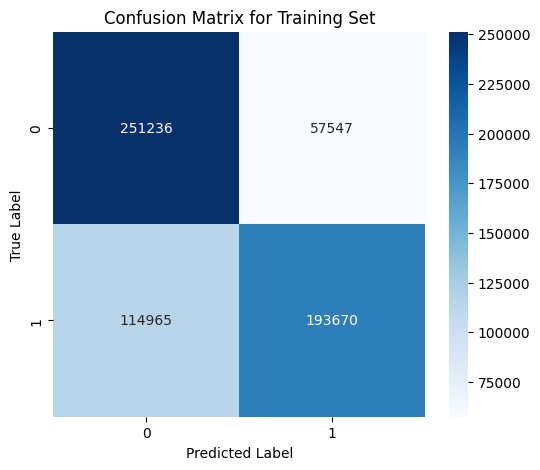

2144/2144 [==============================] - 10s 5ms/step

Results for Test Set:
Accuracy: 0.7130695898078773
Precision: 0.765420054200542
Recall: 0.6162327272727273
F1 Score: 0.6827719580983078


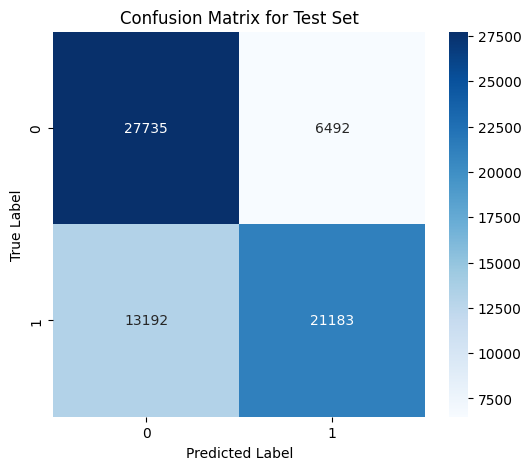

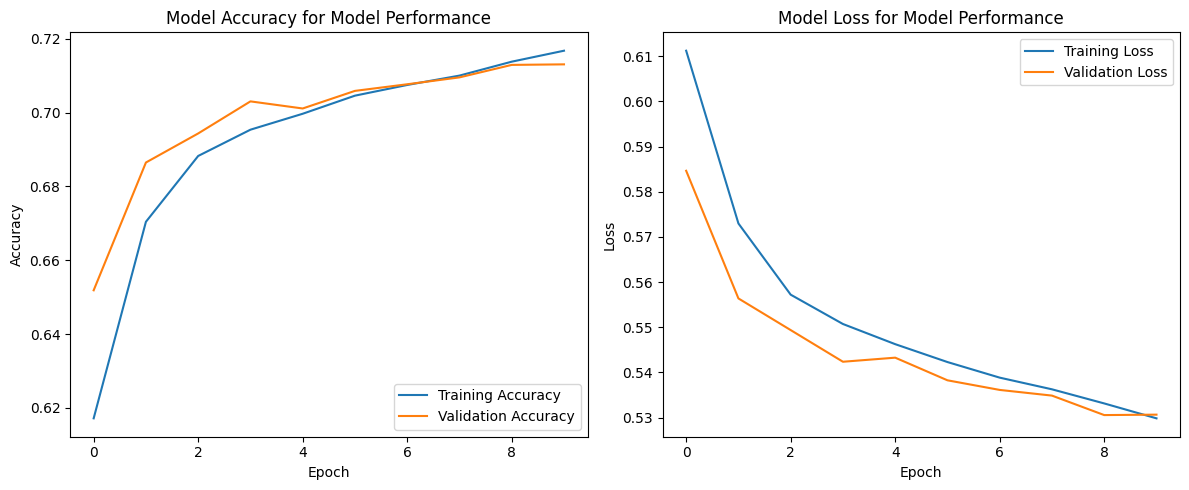

In [29]:
def evaluate_and_visualize(model, X_seq, X_pssm, y, dataset_name):
    # Generate predictions
    predictions = (model.predict([X_seq, X_pssm]) > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions, zero_division=0)
    recall = recall_score(y, predictions, zero_division=0)
    f1 = f1_score(y, predictions, zero_division=0)

    # Print metrics
    print(f"\nResults for {dataset_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Plot confusion matrix
    conf_matrix = confusion_matrix(y, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Evaluate and visualize for training dataset
evaluate_and_visualize(model, X_train_seq, X_train_pssm, y_train, "Training Set")

# Evaluate and visualize for test dataset
evaluate_and_visualize(model, X_test_seq, X_test_pssm, y_test, "Test Set")

plot_training_history(history, title='Model Performance')


# **To generate separate visualizations for each test protein**

In [ ]:
def evaluate_and_visualize_per_protein(model, protein_data, protein_names):
    for protein_name in protein_names:
        X_test_seq, X_test_pssm, y_test = protein_data[protein_name]
        predictions = (model.predict([X_test_seq, X_test_pssm]) > 0.5).astype(int)

        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, zero_division=0)
        recall = recall_score(y_test, predictions, zero_division=0)
        f1 = f1_score(y_test, predictions, zero_division=0)

        print(f"Results for {protein_name}:")
        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

        # Generate confusion matrix plot specific to this protein
        conf_matrix = confusion_matrix(y_test, predictions)
        sns.heatmap(conf_matrix, annot=True, fmt='d')
        plt.title(f'Confusion Matrix for {protein_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()


In [ ]:
for protein_name in test_data_per_protein:
    X_test_seq, X_test_pssm, y_test = test_data_per_protein[protein_name]
    evaluate_and_visualize_per_protein(model, X_test_seq, X_test_pssm, y_test, protein_name)


# Matching Entries in Both Dictionaries
First, ensure that you have matching keys in both rbp_data_dict and pssm_data_dict. This process involves iterating through the keys in one dictionary and checking if they also exist in the other dictionary. When a key exists in both, you can use the corresponding values (sequences from rbp_data_dict and PSSM features from pssm_data_dict) as inputs to your model.

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming rbp_data_dict and pssm_data_dict are already defined
# Ensure the model creation function is already defined

# Prepare your datasets
sequence_data = []
pssm_features = []
labels = []

for key in rbp_data_dict.keys():
    if key in reduced_data_dict:
        num_sequences = len(rbp_data_dict[key]['sequences'])
        sequence_data.extend(rbp_data_dict[key]['sequences'])
        labels.extend(rbp_data_dict[key]['labels'])
        # Each sequence for a given key gets the same reduced PSSM feature array
        for _ in range(num_sequences):
            pssm_features.append(reduced_data_dict[key])

# Convert lists to numpy arrays for model input
sequence_data = np.array(sequence_data)  # This may require additional preprocessing to match your model's input requirements
pssm_features = np.array(pssm_features)
labels = np.array(labels)

# Split the data into training and testing sets
X_seq_train, X_seq_test, X_pssm_train, X_pssm_test, y_train, y_test = train_test_split(
    sequence_data, pssm_features, labels, test_size=0.1, random_state=42
)
max_length = X_seq_train.shape[1]
print(f'Max sequence length: {max_length}')

# Now global_unique_characters contains all unique characters from all sequences in all files
unique_characters = {char: idx for idx, char in enumerate(sorted(global_unique_characters), 1)}
print(f'Reduced PSSM data shape: {reduced_data.shape}')

print(f'X_pssm_train shape: {X_pssm_train.shape}')
print(f'X_pssm_test shape: {X_pssm_test.shape}')



encoding_dim = int(pssm_values.shape[1] * 0.2)  # Example: 20% of the input size
print(f'PSSM encoding dimension: {encoding_dim}')

print(f'Number of unique characters: {len(unique_characters)}')



# Create the model
model = create_model_with_pssm(max_length=max_length, unique_characters=unique_characters, pssm_dim=encoding_dim)
model.summary()
# Train the model
# model.fit([X_seq_train, X_pssm_train], y_train, epochs=2, validation_split=0.1)

# # Evaluate the model
# model.evaluate([X_seq_test, X_pssm_test], y_test)


Max sequence length: 107
Reduced PSSM data shape: (314, 480)
X_pssm_train shape: (185417, 480)
X_pssm_test shape: (20602, 480)
PSSM encoding dimension: 480
Number of unique characters: 6
KerasTensor(type_spec=TensorSpec(shape=(None, 480), dtype=tf.float32, name='pssm_input'), name='pssm_input', description="created by layer 'pssm_input'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence_input (InputLayer  [(None, 107)]                0         []                            
 )                                                                                                
                                                                                                  
 embedding_2 (Embedding)     (None, 107, 128)             896       ['sequence_input[0][0]']      
                                                

# ***Approach 1: Training and Testing on All Data Together***

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_and_visualize(model, X_test_seq, X_test_pssm, y_test, protein_name):
    # Generate predictions
    test_pred = (model.predict([X_test_seq, X_test_pssm]) > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, test_pred)
    precision = precision_score(y_test, test_pred, zero_division=0)
    recall = recall_score(y_test, test_pred, zero_division=0)
    f1 = f1_score(y_test, test_pred, zero_division=0)

    # Print metrics
    print(f"\nResults for {protein_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {protein_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

def plot_training_history(history, title=''):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy for {title}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for {title}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

class Metrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_pred = (self.model.predict(X_train) > 0.5).astype(int)
        test_pred = (self.model.predict(X_test) > 0.5).astype(int)
        metrics = {
            "Training": (y_train, train_pred),
            "Testing": (y_test, test_pred),
        }
        for key, (y, pred) in metrics.items():
            accuracy = accuracy_score(y, pred)
            precision = precision_score(y, pred, zero_division=0)
            recall = recall_score(y, pred, zero_division=0)
            f1 = f1_score(y, pred, zero_division=0)
            print(f"\n{key} - Epoch: {epoch+1}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

PSSM encoding dimension: 480
Number of unique characters: 6
Max sequence length: 107
KerasTensor(type_spec=TensorSpec(shape=(None, 480), dtype=tf.float32, name='pssm_input'), name='pssm_input', description="created by layer 'pssm_input'")
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence_input (InputLayer  [(None, 107)]                0         []                            
 )                                                                                                
                                                                                                  
 embedding_13 (Embedding)    (None, 107, 128)             896       ['sequence_input[0][0]']      
                                                                                                  
 bidirectional_13 (Bidirect  (None, 107, 512)     

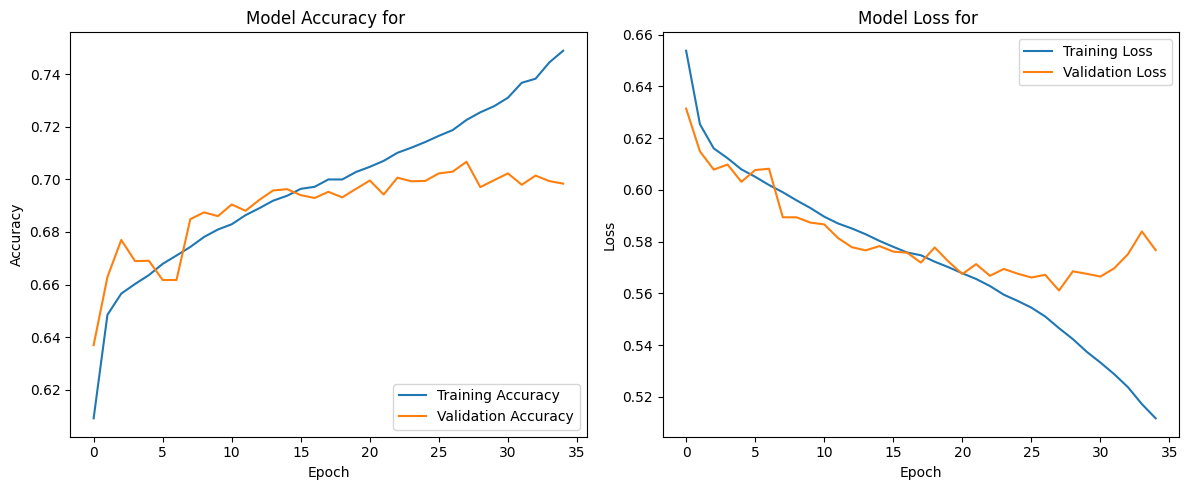

127/127 [==============================] - 2s 10ms/step

Results for ABCF1:
Accuracy: 0.7028430160692213
Precision: 0.6960966542750929
Recall: 0.7321603128054741
F1 Score: 0.7136731777036686


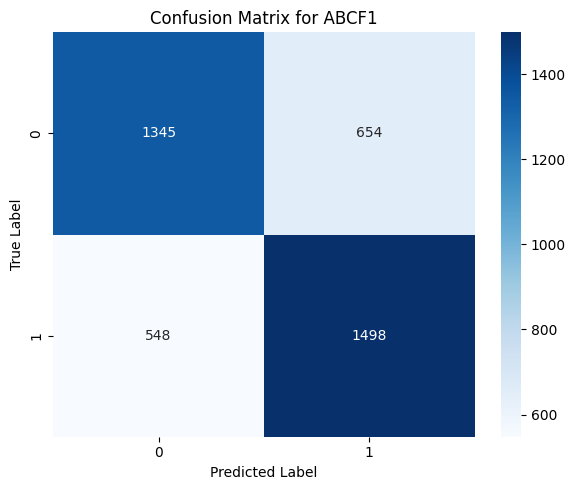

338/338 [==============================] - 2s 5ms/step

Results for AGGF1:
Accuracy: 0.6840740740740741
Precision: 0.6918214901359893
Recall: 0.6670360110803324
F1 Score: 0.6792027077848815


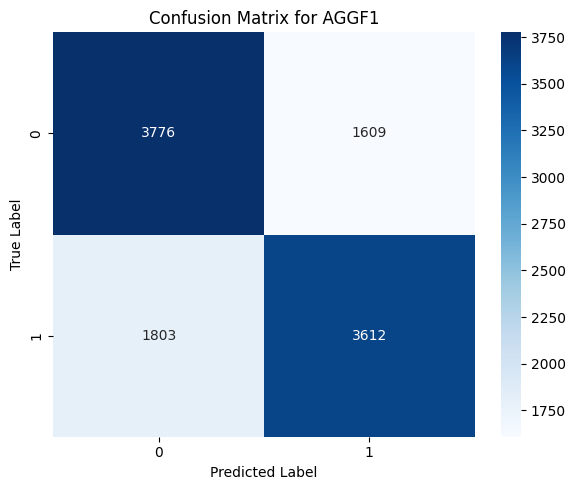

116/116 [==============================] - 1s 5ms/step

Results for AATF:
Accuracy: 0.7018398268398268
Precision: 0.7021390374331551
Recall: 0.7066738428417654
F1 Score: 0.7043991416309013


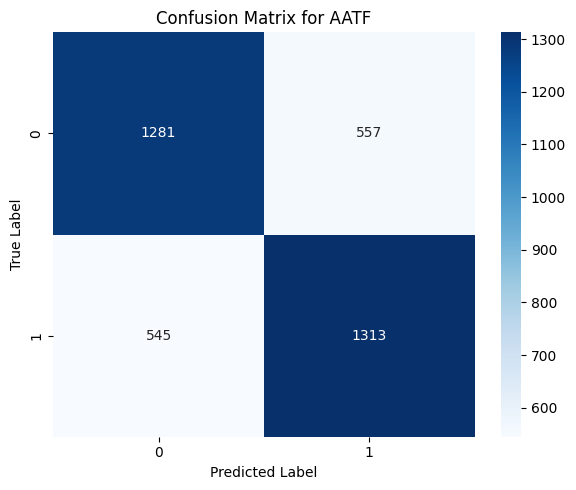

In [ ]:
def split_data_for_protein(protein_name, rbp_data_dict, test_ratio=0.1):
    """Splits the data for a single protein into training and test sets."""
    sequences = rbp_data_dict[protein_name]['sequences']
    labels = rbp_data_dict[protein_name]['labels']
    total_sequences = len(sequences)
    test_size = int(total_sequences * test_ratio)

    # Random selection of indices for the test set
    indices = np.arange(total_sequences)
    np.random.shuffle(indices)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    # Splitting the data
    rbp_data_dict[protein_name]['test_sequences'] = [sequences[i] for i in test_indices]
    rbp_data_dict[protein_name]['test_labels'] = [labels[i] for i in test_indices]
    rbp_data_dict[protein_name]['sequences'] = [sequences[i] for i in train_indices]
    rbp_data_dict[protein_name]['labels'] = [labels[i] for i in train_indices]

# Assuming rbp_data_dict is already defined and populated
for protein_name in rbp_data_dict.keys():
    split_data_for_protein(protein_name, rbp_data_dict)



def prepare_training_data(rbp_data_dict, reduced_data_dict):
    X_seq = []
    X_pssm = []
    y = []

    for protein_name, data in rbp_data_dict.items():
        if protein_name in reduced_data_dict:
            for seq, label in zip(data['sequences'], data['labels']):
                X_seq.append(seq)
                y.append(label)
                X_pssm.append(reduced_data_dict[protein_name])

    # Convert lists to numpy arrays and perform any necessary preprocessing, e.g., padding sequences
    X_seq = np.array(X_seq)  # You may need to pad this
    X_pssm = np.array(X_pssm)
    y = np.array(y)

    return X_seq, X_pssm, y

def prepare_test_data(protein_name, rbp_data_dict, reduced_data_dict):
    X_seq_test = []
    X_pssm_test = []
    y_test = []

    if protein_name in rbp_data_dict and protein_name in reduced_data_dict:
        test_sequences = rbp_data_dict[protein_name]['test_sequences']
        test_labels = rbp_data_dict[protein_name]['test_labels']
        pssm_features = reduced_data_dict[protein_name]

        for seq, label in zip(test_sequences, test_labels):
            X_seq_test.append(seq)
            y_test.append(label)
            X_pssm_test.append(pssm_features)

    # Convert lists to numpy arrays and perform any necessary preprocessing, e.g., padding sequences
    X_seq_test = np.array(X_seq_test)  # You may need to pad this
    X_pssm_test = np.array(X_pssm_test)
    y_test = np.array(y_test)

    return X_seq_test, X_pssm_test, y_test



def train_and_evaluate_model(rbp_data_dict, reduced_data_dict):
    # Preparing training data
    X_train_seq, X_train_pssm, y_train = prepare_training_data(rbp_data_dict, reduced_data_dict)

    # Now global_unique_characters contains all unique characters from all sequences in all files
    unique_characters = {char: idx for idx, char in enumerate(sorted(global_unique_characters), 1)}
    encoding_dim = int(pssm_values.shape[1] * 0.2)  # Example: 20% of the input size
    print(f'PSSM encoding dimension: {encoding_dim}')
    print(f'Number of unique characters: {len(unique_characters)}')
    max_length = X_seq_train.shape[1]
    print(f'Max sequence length: {max_length}')

    # Create the model
    model = create_model_with_pssm(max_length=max_length, unique_characters=unique_characters, pssm_dim=encoding_dim)
    model.summary()

    # Train your model on the training data
    history = model.fit([X_train_seq, X_train_pssm], y_train, validation_split=0.1, epochs=35)
    plot_training_history(history)

    # Evaluation loop for each protein's test data
    for protein_name in rbp_data_dict.keys():
        if 'test_sequences' in rbp_data_dict[protein_name]:  # Ensure the test data is available
            X_test_seq, X_test_pssm, y_test = prepare_test_data(protein_name, rbp_data_dict, reduced_data_dict)
            evaluate_and_visualize(model, X_test_seq, X_test_pssm, y_test, protein_name)

# Assuming `rbp_data_dict` and `reduced_data_dict` are already defined and filled with your data
train_and_evaluate_model(rbp_data_dict, reduced_data_dict)


In [ ]:
if 'test_sequences' in rbp_data_dict['AATF']:
    print("Test sequences key is present for AATF.")
else:
    print("Test sequences key is missing for AATF.")


Test sequences key is missing for AATF.


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming rbp_data_dict and pssm_data_dict are already defined
# Ensure the model creation function is already defined

# Prepare your datasets
sequence_data = []  # Initialize as an empty list
pssm_features = []
labels = []

for key in rbp_data_dict.keys():
    if key in reduced_data_dict:
        num_sequences = len(rbp_data_dict[key]['sequences'])
        sequence_data.extend(rbp_data_dict[key]['sequences'])  # Now correctly using a list method
        labels.extend(rbp_data_dict[key]['labels'])
        # Each sequence for a given key gets the same reduced PSSM feature array
        for _ in range(num_sequences):
            pssm_features.append(reduced_data_dict[key])

# Convert lists to numpy arrays for model input
sequence_data = np.array(sequence_data)  # This may require additional preprocessing to match your model's input requirements
pssm_features = np.array(pssm_features)
labels = np.array(labels)

X_seq_train, X_seq_test, X_pssm_train, X_pssm_test, y_train, y_test = train_test_split(
    sequence_data, pssm_features, labels, test_size=0.1, random_state=42
)


# Now global_unique_characters contains all unique characters from all sequences in all files
unique_characters = {char: idx for idx, char in enumerate(sorted(global_unique_characters), 1)}
encoding_dim = int(pssm_values.shape[1] * 0.2)  # Example: 20% of the input size
print(f'PSSM encoding dimension: {encoding_dim}')
print(f'Number of unique characters: {len(unique_characters)}')
max_length = X_seq_train.shape[1]
print(f'Max sequence length: {max_length}')


# Create the model
model = create_model_with_pssm(max_length=max_length, unique_characters=unique_characters, pssm_dim=encoding_dim)
model.summary()



# Instantiate the metrics callback
# metrics_callback = Metrics(X_train=X_seq_train, y_train=y_train, X_test=X_seq_test, y_test=y_test)

# Now you can use this callback in your model.fit call without the NameError
history = model.fit(
    [X_seq_train, X_pssm_train], y_train,
    validation_data=([X_seq_test, X_pssm_test], y_test),
    epochs=25,
    batch_size=32,
    # callbacks=[metrics_callback]  # Use the instantiated callback here
)

# Generate predictions for confusion matrices
train_pred = (model.predict([X_seq_train, X_pssm_train]) > 0.5).astype(int)
test_pred = (model.predict([X_seq_test, X_pssm_test]) > 0.5).astype(int)

# Generate and plot confusion matrices
plot_confusion_matrices(y_train, train_pred, y_test, test_pred)

# Plot training and validation accuracy and loss
plot_training_history(history)



PSSM encoding dimension: 480
Number of unique characters: 6
Max sequence length: 107
KerasTensor(type_spec=TensorSpec(shape=(None, 480), dtype=tf.float32, name='pssm_input'), name='pssm_input', description="created by layer 'pssm_input'")
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence_input (InputLayer  [(None, 107)]                0         []                            
 )                                                                                                
                                                                                                  
 embedding_8 (Embedding)     (None, 107, 128)             896       ['sequence_input[0][0]']      
                                                                                                  
 bidirectional_8 (Bidirecti  (None, 107, 512)     

KeyboardInterrupt: 

# **Approach 1: Train and Evaluate Models Separately for Each RBP**
In this approach, you iterate over each RBP, preparing its specific dataset for training and evaluation, and then train the model on this dataset. After training, you evaluate and visualize the performance for each RBP individually.

In [ ]:
# Loop over each RBP and its corresponding PSSM data
for protein_name, data in rbp_data_dict.items():
    if protein_name not in reduced_data_dict:
        print(f"Skipping {protein_name} as no PSSM data is available.")
        continue

    sequences = np.array(data['sequences'])
    labels = np.array(data['labels'])
    pssm_features = np.array(reduced_data_dict[protein_name])



    # Assuming max_length and unique_characters are globally defined or computed here
    X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.1, random_state=42)
    X_pssm_train, X_pssm_test = train_test_split(pssm_features, test_size=0.1, random_state=42)

    # Assuming pssm_features is the PSSM feature array for the current protein
    # And X_train has the shape (num_samples, sequence_length)
    pssm_features_replicated = np.tile(pssm_features, (X_train.shape[0], 1))


    max_length = X_train.shape[1]
    print(f'Max sequence length: {max_length}')

    # Now global_unique_characters contains all unique characters from all sequences in all files
    unique_characters = {char: idx for idx, char in enumerate(sorted(global_unique_characters), 1)}
    print(f'Number of unique characters: {len(unique_characters)}')
    print(f'Reduced PSSM data shape: {reduced_data.shape}')




    encoding_dim = int(pssm_values.shape[1] * 0.2)  # Example: 20% of the input size
    print(f'PSSM encoding dimension: {encoding_dim}')

    # Use the defined model architecture
    model = create_model_with_pssm(max_length, global_unique_characters, encoding_dim)


    history = model.fit(
        [X_train, pssm_features_replicated], y_train,
        validation_split=0.1,
        epochs=2,
        batch_size=32
    )

    # Evaluate and visualize for each RBP
    evaluate_and_visualize(model, X_test, pssm_features, y_test, protein_name)
    plot_training_history(history, protein_name)


Max sequence length: 107
Number of unique characters: 6
Reduced PSSM data shape: (314, 480)
PSSM encoding dimension: 480
Epoch 1/2
1138/1138 [==============================] - 25s 16ms/step - loss: 0.6563 - accuracy: 0.6065 - val_loss: 0.6400 - val_accuracy: 0.6174
Epoch 2/2
1138/1138 [==============================] - 18s 16ms/step - loss: 0.6377 - accuracy: 0.6338 - val_loss: 0.6244 - val_accuracy: 0.6436


ValueError: Data cardinality is ambiguous:
  x sizes: 4496, 480
Make sure all arrays contain the same number of samples.

In [ ]:
# Combine all data
all_sequences = np.concatenate([np.array(data['sequences']) for data in rbp_data_dict.values()])
all_labels = np.concatenate([np.array(data['labels']) for data in rbp_data_dict.values()])
all_pssm_features = np.concatenate([np.array(reduced_data_dict[name]) for name in rbp_data_dict if name in reduced_data_dict])

# Train-test split on the combined dataset
X_train, X_test, y_train, y_test = train_test_split(all_sequences, all_labels, test_size=0.1, random_state=42)
X_pssm_train, X_pssm_test = train_test_split(all_pssm_features, test_size=0.1, random_state=42)

# Train the model on the combined dataset
model = create_model_with_pssm(max_length, len(unique_characters), all_pssm_features.shape[1])
# Assuming X_seq_train, X_pssm_train, y_train are combined datasets of all RBPs
history = model.fit(
    [X_seq_train, X_pssm_train], y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32
)

# After training, evaluate for each RBP individually
for protein_name, data in rbp_data_dict.items():
    if protein_name not in reduced_data_dict:
        continue  # Skip if no PSSM data

    # Assuming you have a way to access or split X_test_seq, X_test_pssm, y_test for each protein
    evaluate_and_visualize(model, X_test_seq[protein_name], X_test_pssm[protein_name], y_test[protein_name], protein_name)

